In [265]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm


## Preprocessing

In [246]:
def load_evaluation_files(base_folders=None, root_path=".", metadata=True):
    """
    Load all .json files from the 'evaluation' subdirectories of specified folders.

    Args:
        base_folders (list): List of folders to look for (e.g., ['testset1', 'testset3', 'testset4']).
        root_path (str): The root path where the base folders are located (default is the current directory).

    Returns:
        dict: A dictionary where keys are file paths and values are the parsed JSON data.
    """
    all_data = {}
    if base_folders is None:
        base_folders = [folder.name for folder in Path(root_path).iterdir() if folder.is_dir()]
    
    print(base_folders)
    for folder in base_folders:
        eval_path = os.path.join(root_path, folder,"**",  "evaluation","**", "*.json")
        json_files = glob.glob(eval_path, recursive = True)

        for file_path in json_files:
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    all_data[str(file_path)] = {}
                    all_data[str(file_path)]["solution"] = data["solution"]
                    if metadata:
                        all_data[str(file_path)]["metadata"] = data["metadata"]
                    if "solution_combined" in data.keys():
                        all_data[str(file_path)]["solution_combined"] = data["solution_combined"]
            except Exception as e:
                del all_data[str(file_path)]
                print(f"Error loading {file_path}: {e}")
    
    
    return all_data

In [247]:
def generate_pandas_df(data, online:bool=False):
    for file_path, values in data.items():
        solution = {file_path : values["solution"]}
        metadata = {file_path : values["metadata"]}
        df = pd.DataFrame.from_dict(solution, orient="index")
        meta_df = pd.DataFrame.from_dict(metadata, orient="index")
        
        if 'solution_combined' in values.keys():
            combined = {file_path : values["solution_combined"]}
            combined_df = pd.DataFrame.from_dict(combined, orient="index")
        
        df = pd.concat([df, meta_df], axis=1)
        
    df = pd.DataFrame.from_dict(data, orient="index")
    solution_norm = pd.json_normalize(df["solution"]).set_index(df.index)
    metadata_norm = pd.json_normalize(df["metadata"]).set_index(df.index)

    # combine the two normalized dfs
    df_normalized = df.drop(["solution", "metadata"], axis=1)\
                    .join(solution_norm, rsuffix='_sol')\
                    .join(metadata_norm, rsuffix='_meta')
    df_normalized.reset_index(inplace=True)
    df_normalized['config_name'] = df_normalized["index"].apply(lambda x: x.split('/')[1]) + df_normalized["index"].apply(lambda x: x.split('/')[-1])
    df_normalized["solution_type"] = df_normalized["index"].apply(lambda x: x.split('/')[-2])
    df_normalized.set_index('index', inplace=True)

    if online: 
        combined_df = pd.json_normalize(df_normalized["solution_combined"]).set_index(df.index)
        combined_df = df_normalized.drop(['solution_combined'], axis=1).join(combined_df, rsuffix='_combined', how="left")
        df_normalized.drop(columns=['solution_combined'], inplace=True)
        
        return combined_df, combined_df
    else:
        return df_normalized

def pre_process_df(df:pd.DataFrame):
    df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
    
    df = df.sort_values(by=['config_name', 'objective'])

    # Calculate the absolute difference to best performing allocation: 
    df_shortened = df[['set_ident', 'solution_type', 'objective', 'release_times']]
    df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")
    
    # Get heuristic value
    heuristic_df = df_shortened[df_shortened["solution_type"] == "heuristic"][["set_ident", "objective"]]
    heuristic_df = heuristic_df.rename(columns={"objective": "heur_objective"})

    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(heuristic_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get enthropy value
    enthropy_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", 'tasks', "enthropy"]]
    df = df.drop(columns=["enthropy"])
    # Normalize entropy for each config_name
    enthropy_df['normalized_entropy'] = enthropy_df[['tasks', "enthropy"]].groupby('tasks')['enthropy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    enthropy_df['normalized_entropy_all'] = enthropy_df[["enthropy"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(enthropy_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get parallelity value
    parallelity_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", "parallelity"]]
    parallelity_df['parallelity_norm'] = parallelity_df[["parallelity"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df = df.drop(columns=["parallelity"])
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(parallelity_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)
    
    df_shortened["makespan_deviation"] = df_shortened["objective"] - df_shortened["min_objective"]
    df_shortened["deviation_to_heur"] = df_shortened["objective"] - df_shortened["heur_objective"]


    # Relative makespan deviation
    df_shortened['relative_makespan_deviation'] = df_shortened["makespan_deviation"]/ df_shortened["min_objective"]
    df_shortened['relative_makespan_deviation'] = (df_shortened['relative_makespan_deviation']*100.).round(2)
    
    df_shortened["release_type"] = df_shortened["release_times"].apply(
        lambda x: "arrival" if type(x) is float or len(set(x)) > 1 else "same_release"
    )

    df = df.join(df_shortened[['makespan_deviation', 'relative_makespan_deviation', 'release_type', 'min_objective', 'deviation_to_heur', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'parallelity', 'parallelity_norm']])
    # calculate resource standard deviation: 
    cols_to_conv =['resource_importance.res_1', 'resource_importance.res_2', 'resource_importance.res_3', 'resource_importance.res_4']
    df[cols_to_conv] = df[cols_to_conv].astype(float)
    df['res_std_dev'] = df[cols_to_conv].std(axis=1)

    return df

In [248]:
base_folders=['10_instantArr', '10_generated']
data = load_evaluation_files(base_folders, root_path = "testsets_decomposed_pipe")
print(f"{len(data)} datasets loaded")

['10_instantArr', '10_generated']
36 datasets loaded


In [249]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound']].set_index('config_name')

/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [250]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)

# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", "gap", 'best_gap'])

# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
df_pivot

Solution Type                                      all_instance_cp_3600  \
                                                           0 LowerBound   
config_name                                                               
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                  NaN   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                  NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                  NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                  NaN   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                  NaN   
10_generatedsimple-10.json                                          NaN   
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...                   21   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...                   29   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                   23   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...                   14   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...                   21   
10_instantArrsimple-10.json                                         132   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...          NaN    NaN   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...          NaN    NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          NaN    NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          NaN    NaN   
10_generated(1, 0, 0.0)-random-3-uniform-normal...          NaN    NaN   
10_generatedsimple-10.json                                  NaN    NaN   
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...           94  77.7%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...          143  79.7%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...          179  87.2%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...           81  82.7%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...          101  79.2%   
10_instantArrsimple-10.json                                 132   0.0%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...              NaN   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...              NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...              NaN   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...              NaN   
10_generated(1, 0, 0.0)-random-3-uniform-normal...              NaN   
10_generatedsimple-10.json                                      NaN   
10_instantArr(0.6, 0.4, 0.0)-random-3-uniform-r...            23.4%   
10_instantArr(0.6, 0.4, 0.0)-skill_short_branch...             9.1%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...             5.0%   
10_instantArr(0.8, 0.2, 0.0)-skill_short_branch...            11.1%   
10_instantArr(1, 0, 0.0)-random-3-uniform-norma...            23.8%   
10_instantArrsimple-10.json                                    0.0%   

Solution Type                                      all_instance_cp_3600_gen  \
                                                               0 LowerBound   
config_name                                                                   
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                       46   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                       55   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       79   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       51   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                       58   
10_generatedsimple-10.json                                       

# Offline tests

In [251]:
base_folders=['10_instantArr']
data = load_evaluation_files(root_path = "testsets_decomposed_final_8_freeze")
print(f"{len(data)} datasets loaded")

['clinic_test', '10_tasks', 'random_instances', '5_tasks']
24 datasets loaded


In [252]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound']].set_index('config_name')

/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [253]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)

# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", "gap", 'best_gap'])

# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
df_pivot

Solution Type                                      all_instance_cp_7200_gen  \
                                                               0 LowerBound   
config_name                                                                   
10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resour...                       21   
10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-un...                       14   
10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1...                       21   
5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ear...                      102   
5_taskssimple_5.json                                                     63   
clinic_testClinic_res.json                                              115   
random_instances(1, 0, 0.0)-random-3-uniform-no...                       25   
random_instances(1, 0, 0.0)-skill_short_branch-...                       29   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resour...           94  77.7%   
10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-un...           81  82.7%   
10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1...          101  79.2%   
5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ear...          102   0.0%   
5_taskssimple_5.json                                         63   0.0%   
clinic_testClinic_res.json                                  115   0.0%   
random_instances(1, 0, 0.0)-random-3-uniform-no...           91  72.5%   
random_instances(1, 0, 0.0)-skill_short_branch-...           93  68.8%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resour...            23.4%   
10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-un...            11.1%   
10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1...            23.8%   
5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ear...             0.0%   
5_taskssimple_5.json                                           0.0%   
clinic_testClinic_res.json                                     0.0%   
random_instances(1, 0, 0.0)-random-3-uniform-no...             3.3%   
random_instances(1, 0, 0.0)-skill_short_branch-...             3.2%   

Solution Type                                      all_instance_cp_decomposed_7200_gen  \
                                                                          0 LowerBound   
config_name                                                                              
10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resour...                                  72   
10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-un...                                  72   
10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1...                                  77   
5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ear...                                 102   
5_taskssimple_5.json                                                                56   
clinic_testClinic_res.json                                                         100   
random_instances(1, 0, 0.0)-random-3-uniform-no...                                  88   
random_instances(1, 0, 0.0)-skill_short_branch-...                                  90   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resour...          103  30.1%   
10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-un...           94  23.4%   
10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1...          112  31.2%   
5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ear...          102   0.0%   
5_taskssimple_5.json    

# Online Tests


In [254]:
data = load_evaluation_files(root_path = "testsets_online_final_freeze")
print(f"{len(data)} datasets loaded")

['10_generated_random', '20_generated_random', '10_generated', '30_generated', '30_generated_random', '20_generated']


180 datasets loaded


In [255]:
df, combined_df = generate_pandas_df(data, online=True)
df = df[df["solution_type"] != "all_instance_ilp"]
df = pre_process_df(df)

/tmp/ipykernel_1831574/1593244946.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [256]:
df

,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,ilp_runtime,...,relative_makespan_deviation,release_type,min_objective,deviation_to_heur,enthropy,normalized_entropy,normalized_entropy_all,parallelity,parallelity_norm,res_std_dev
index,,,,,,,,,,,,,,,,,,,,,
"testsets_online_final_freeze/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",97.0,N/A,50.0,100.050000,Feasible,18448417.0,N/A,345.0,NaN,NaN,...,0.00,arrival,97.0,-35.0,0.555786,0.000000,0.000000,0.903846,0.726810,2.283451
"testsets_online_final_freeze/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",106.0,N/A,106.0,0.380000,Optimal,78457.0,N/A,326.0,NaN,NaN,...,9.28,arrival,97.0,-26.0,0.555786,0.000000,0.000000,0.903846,0.726810,2.283451
"testsets_online_final_freeze/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",118.0,N/A,118.0,0.140000,Optimal,170087.0,N/A,312.0,39.0,0.000263,...,21.65,arrival,97.0,-14.0,0.555786,0.000000,0.000000,0.903846,0.726810,2.283451
"testsets_online_final_freeze/10_generated/evaluation/single_instance_cp_no_sigma/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",119.0,N/A,119.0,0.260000,Optimal,92562.0,N/A,337.0,NaN,NaN,...,22.68,arrival,97.0,-13.0,0.555786,0.000000,0.000000,0.903846,0.726810,2.283451
"testsets_online_final_freeze/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",132.0,NaN,NaN,0.525737,NaN,NaN,NaN,337.0,NaN,NaN,...,36.08,arrival,97.0,0.0,0.555786,0.000000,0.000000,0.903846,0.726810,2.283451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_online_final_freeze/30_generated_random/evaluation/all_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",381.0,N/A,140.0,100.220000,Feasible,4069547.0,N/A,1595.0,NaN,NaN,...,0.00,arrival,381.0,-36.0,0.830268,0.545584,0.380259,0.971264,0.964757,3.158282
"testsets_online_final_freeze/30_generated_random/evaluation/heuristic/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",417.0,NaN,NaN,12.061201,NaN,NaN,NaN,1505.0,NaN,NaN,...,9.45,arrival,381.0,0.0,0.830268,0.545584,0.380259,0.971264,0.964757,3.158282
"testsets_online_final_freeze/30_generated_random/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",473.0,N/A,473.0,361.210000,Optimal,6126523.0,N/A,1422.0,NaN,NaN,...,24.15,arrival,381.0,56.0,0.830268,0.545584,0.380259,0.971264,0.964757,3.158282


In [257]:
objective_df = df[['set_ident', 'tasks', 'solution_type', 'objective', 'makespan_deviation', 'relative_makespan_deviation', 'optimality_gap']]
#objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")
objective_df["optimal_count"] = objective_df["optimality_gap"].apply(lambda x: x.count(0)if isinstance(x, list) else np.nan).astype(float)
objective_df["instances"] = objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else np.nan).astype(float)
objective_df["optimal_percentage"] = objective_df["optimal_count"] / objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else 1)
objective_df

/tmp/ipykernel_1831574/1184842815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objective_df["optimal_count"] = objective_df["optimality_gap"].apply(lambda x: x.count(0)if isinstance(x, list) else np.nan).astype(float)
/tmp/ipykernel_1831574/1184842815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objective_df["instances"] = objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else np.nan).astype(float)
/tmp/ipykernel_1831574/1184842815.py:5: SettingWithCopyWarning: 
A va

,set_ident,tasks,solution_type,objective,makespan_deviation,relative_makespan_deviation,optimality_gap,optimal_count,instances,optimal_percentage
index,,,,,,,,,,
"testsets_online_final_freeze/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,all_instance_cp,97.0,0.0,0.00,NaN,NaN,NaN,NaN
"testsets_online_final_freeze/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_cp,106.0,9.0,9.28,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_online_final_freeze/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_ilp,118.0,21.0,21.65,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_online_final_freeze/10_generated/evaluation/single_instance_cp_no_sigma/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_cp_no_sigma,119.0,22.0,22.68,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_online_final_freeze/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,heuristic,132.0,35.0,36.08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
"testsets_online_final_freeze/30_generated_random/evaluation/all_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",30,30,all_instance_cp,381.0,0.0,0.00,NaN,NaN,NaN,NaN
"testsets_online_final_freeze/30_generated_random/evaluation/heuristic/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",30,30,heuristic,417.0,36.0,9.45,NaN,NaN,NaN,NaN
"testsets_online_final_freeze/30_generated_random/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_0.json",30,30,single_instance_cp,473.0,92.0,24.15,"[0, 0, 0, 0, 45, 0, 0, 0]",7.0,8.0,0.875


In [258]:
# Assuming `df` is your original dataframe
df_filtered = objective_df.dropna(subset=["solution_type", "tasks"])  # Ensure valid data
df_grouped = df_filtered.groupby(["solution_type", "tasks"]).agg(
    mean_makespan_dev=("makespan_deviation", "mean"),
    sum_opt_count=("optimal_count", "sum"),
    sum_inst_count=("instances", "sum"),
    sum_opt_perc=("optimal_percentage", "mean")
).reset_index()
df_grouped["sum_opt_perc"] *= 100
df_grouped["sum_opt_perc"] = df_grouped[["sum_opt_perc"]].applymap(lambda x: f"{x:.1f}%")
df_grouped["opt_share"] = df_grouped["sum_opt_count"].astype(int).astype(str) + '/' + df_grouped["sum_inst_count"].astype(int).astype(str)
df_grouped  = df_grouped[["solution_type", "tasks", "mean_makespan_dev","opt_share", "sum_opt_perc"]]
df_grouped

/tmp/ipykernel_1831574/2697054940.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grouped["sum_opt_perc"] = df_grouped[["sum_opt_perc"]].applymap(lambda x: f"{x:.1f}%")


,solution_type,tasks,mean_makespan_dev,opt_share,sum_opt_perc
0,all_instance_cp,10,0.0,0/0,nan%
1,all_instance_cp,20,0.0,0/0,nan%
2,all_instance_cp,30,1.8,0/0,nan%
3,heuristic,10,30.1,0/0,nan%
4,heuristic,20,26.4,0/0,nan%
5,heuristic,30,47.1,0/0,nan%
6,single_instance_cp,10,21.9,80/80,100.0%
7,single_instance_cp,20,37.0,75/80,93.8%
8,single_instance_cp,30,58.1,54/80,67.5%
9,single_instance_cp_no_sigma,10,38.4,80/80,100.0%


In [259]:
# Pivot to get desired column names
df_pivot = df_grouped.pivot(index="solution_type", columns="tasks")
# Swap levels so that 'tasks' becomes the top-level header
df_pivot = df_pivot.swaplevel(axis=1)

custom_order = ["mean_makespan_dev", "opt_share", "sum_opt_perc"]
df_pivot.columns = df_pivot.columns.set_levels(
    pd.CategoricalIndex(df_pivot.columns.levels[1], categories=custom_order, ordered=True), 
    level=1
)
df_pivot = df_pivot.sort_index(axis=1, level=0, sort_remaining=True)
df_pivot = df_pivot.sort_values(by=('10', "mean_makespan_dev"), ascending=True)

df_pivot = df_pivot.rename(columns={"mean_makespan_dev":"Deviation", "opt_share": "Optimal", "sum_opt_perc":"Percentage"})
df_pivot

tasks                              10                           20          \
                            Deviation Optimal Percentage Deviation Optimal   
solution_type                                                                
all_instance_cp                   0.0     0/0       nan%       0.0     0/0   
single_instance_cp               21.9   80/80     100.0%      37.0   75/80   
heuristic                        30.1     0/0       nan%      26.4     0/0   
single_instance_cp_no_sigma      38.4   80/80     100.0%      71.7   78/80   
single_instance_ilp              58.4   80/80     100.0%      95.0   80/80   

tasks                                         30                     
                            Percentage Deviation Optimal Percentage  
solution_type                                                        
all_instance_cp                   nan%       1.8     0/0       nan%  
single_instance_cp               93.8%      58.1   54/80      67.5%  
heuristic                         nan%      47.1     0/0       nan%  
single_instance_cp_no_sigma      97.5%     123.3   72/80      90.0%  
single_instance_ilp             100.0%     119.5   80/80     100.0%

In [266]:
SHOW_FIGURES=False
if not SHOW_FIGURES:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble' : r'\newcommand{\mathdefault}[1][]{}'
    })

In [271]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

# rename solution types:
rename_dict = {
    "all_instance_cp": "Oracle CP",
    "single_instance_cp": "Resched. CP",
    "heuristic": "Heuristic",
    "single_instance_ilp": "Resched. ILP",
    "single_instance_cp_no_sigma": "No Resched. CP"
}
visual_df["solution_type"] = visual_df["solution_type"].replace(rename_dict)
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)

marker_dict = {
    "Oracle CP": "x",
    "Resched. CP": "o",
    "No Resched. CP": "x",
    "Heuristic": "D",
    "all_instance_ilp": "^",
    "Resched. ILP": "s"
}

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
plot =sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    markers=[marker_dict[s] for s in visual_df["solution_type"].unique()],
    scatter_kws={'s': 20, 'alpha': 0.8},  # Customize scatter points
    line_kws={'linewidth': 1.25},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
)

# exclude one point of ILP from representation
plt.ylim(0, 100)
# Add labels and title
# Remove extra legends
plot._legend.remove()
plt.xlabel("Normalized Entropy in Dataset", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation over Normalized Entropy in Dataset", fontsize=14)
plt.legend(title="Solution Type", fontsize=11, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
plt.savefig("makespan_def_entropy.pdf", format="pdf", bbox_inches="tight")
plt.savefig("makespan_def_entropy.pgf", format="pgf", bbox_inches="tight")


/tmp/ipykernel_1831574/3636167213.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df["solution_type"] = visual_df["solution_type"].replace(rename_dict)
/tmp/ipykernel_1831574/3636167213.py:49: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


## Combination for all Datasets

In [161]:
combined_df

,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,ilp_runtime,...,config.resource_skill_factor,config.single_resource_option_per_task,config_name,solution_type,objective_combined,solver_status,lower_bound_combined,optimality_gap,computing_time,set_ident
index,,,,,,,,,,,,,,,,,,,,,
"testsets_online_final_freeze/10_generated_random/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-2-10_1.json",121.0,N/A,121.0,1.54,Optimal,51940.0,N/A,365.0,NaN,NaN,...,0.6,true,"10_generated_random(0.6, 0.4, 0.0)-random-3-un...",single_instance_cp,"[34, 34, 54, 80, 80, 90, 121, 121]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[34, 34, 54, 80, 80, 90, 121, 121]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.22, 0.09, 0.34, 0.11, 0.09, 0.51, 0.12, 0.06]",9
"testsets_online_final_freeze/10_generated_random/evaluation/single_instance_cp/(1, 0, 0.0)-random-3-early-resource_based-3-1-10_0.json",138.0,N/A,138.0,1.44,Optimal,73898.0,N/A,393.0,NaN,NaN,...,0.6,true,"10_generated_random(1, 0, 0.0)-random-3-early-...",single_instance_cp,"[39, 69, 69, 72, 86, 87, 104, 138]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 69, 69, 72, 86, 87, 104, 138]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.03, 0.08, 0.03, 0.11, 0.04, 0.11, 0.95, 0.09]",10
"testsets_online_final_freeze/10_generated_random/evaluation/single_instance_cp_no_sigma/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-2-10_1.json",136.0,N/A,136.0,0.67,Optimal,55226.0,N/A,386.0,NaN,NaN,...,0.6,true,"10_generated_random(0.6, 0.4, 0.0)-random-3-un...",single_instance_cp_no_sigma,"[34, 34, 56, 78, 78, 111, 136, 136]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[34, 34, 56, 78, 78, 111, 136, 136]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.16, 0.05, 0.12, 0.07, 0.04, 0.1, 0.07, 0.06]",9
"testsets_online_final_freeze/10_generated_random/evaluation/single_instance_cp_no_sigma/(1, 0, 0.0)-random-3-early-resource_based-3-1-10_0.json",144.0,N/A,144.0,0.57,Optimal,74645.0,N/A,372.0,NaN,NaN,...,0.6,true,"10_generated_random(1, 0, 0.0)-random-3-early-...",single_instance_cp_no_sigma,"[39, 69, 73, 73, 86, 108, 115, 144]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 69, 73, 73, 86, 108, 115, 144]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.04, 0.09, 0.05, 0.05, 0.03, 0.12, 0.1, 0.09]",10
"testsets_online_final_freeze/10_generated_random/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-2-10_1.json",103.0,N/A,103.0,0.07,Optimal,112118.0,N/A,318.0,34.0,0.000259,...,0.6,true,"10_generated_random(0.6, 0.4, 0.0)-random-3-un...",all_instance_ilp,NaN,NaN,NaN,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_online_final_freeze/20_generated/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-random-3-uniform-resource_based-2-1-20.json",342.0,N/A,342.0,0.15,Optimal,146606.0,N/A,784.0,98.0,0.000246,...,0.6,true,"20_generated(0.8, 0.2, 0.0)-random-3-uniform-r...",single_instance_ilp,"[98, 129, 162, 198, 234, 270, 306, 342]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[98, 129, 162, 198, 234, 270, 306, 342]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03]",14
"testsets_online_final_freeze/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-4-1-20.json",242.0,N/A,242.0,0.24,Optimal,319366.0,N/A,608.0,76.0,0.000315,...,0.6,true,"20_generated(0.6, 0.4, 0.0)-skill_short_branch...",single_instance_ilp,"[76, 91, 102, 127, 144, 211, 227, 242]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[76, 91, 102, 127, 144, 211, 227, 242]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.05, 0.08]",13
"testsets_online_final_freeze/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-early-normal-3-1-20.json",209.0,N/A,209.0,0.24,Optimal,175614.0,N/A,680.0,85.0,0.000311,...,0.6,true,"20_generated(0.6, 0.4, 0.0)-random-3-early-nor...",single_instance_i

# Backup


### Extra for Clinic Set

In [162]:
base_folders=['10_instantArr']
data = load_evaluation_files(root_path = "testsets_decomposed_final_8", metadata=False)
print(f"{len(data)} datasets loaded")

['clinic_test', '10_tasks', 'random_instances', '5_tasks']
24 datasets loaded


In [163]:
base_folders=['10_generated']
data = load_evaluation_files(base_folders, root_path = "testsets_decomposed_pipe")
print(f"{len(data)} datasets loaded")

['10_generated']
18 datasets loaded


In [164]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound']].set_index('config_name')

/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [165]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)

# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", "gap", 'best_gap'])

# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
df_pivot

Solution Type                                      all_instance_cp_3600_gen  \
                                                               0 LowerBound   
config_name                                                                   
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                       46   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                       55   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       79   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                       51   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                       58   
10_generatedsimple-10.json                                              136   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...          103  55.3%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...          155  64.5%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          213  62.9%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          102  50.0%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...          112  48.2%   
10_generatedsimple-10.json                                  136   0.0%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...            30.1%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...            16.1%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            29.4%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...            25.9%   
10_generatedsimple-10.json                                     0.0%   

Solution Type                                      all_instance_cp_decomposed_3600_gen  \
                                                                          0 LowerBound   
config_name                                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...                                  72   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...                                 130   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                                 169   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...                                  71   
10_generated(1, 0, 0.0)-random-3-uniform-normal...                                  83   
10_generatedsimple-10.json                                                         120   

Solution Type                                                           \
                                                   1 UpperBound  2 Gap   
config_name                                                              
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...          107  32.7%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...          164  20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          216  21.8%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...          106  33.0%   
10_generated(1, 0, 0.0)-random-3-uniform-normal...          122  32.0%   
10_generatedsimple-10.json                                  136  11.8%   

Solution Type                                                        \
                                                   3 Gap to best LB   
config_name                                                           
10_generated(0.6, 0.4, 0.0)-random-3-uniform-re...            32.7%   
10_generated(0.6, 0.4, 0.0)-skill_short_branch-...            20.7%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            21.8%   
10_generated(0.8, 0.2, 0.0)-skill_short_branch-...            32.1%   
10_gen

## Further analysis

In [166]:
testsets_to_load = ["testsets8", "testsets7", "testsets6"]
base_folders=['10_instantArr', '20_instantArr', '30_instantArr']
base_folders=['10_instantArr', '10_generated']
data = load_evaluation_files( root_path = "testsets_random_paper_smaller")
print(f"{len(data)} datasets loaded")


['10_generated', '30_generated', '20_generated']
100 datasets loaded


In [167]:
df, combined_solution_df = generate_pandas_df(data, online=True)
df_raw = pre_process_df(df)
df_raw

/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,ilp_runtime,...,relative_makespan_deviation,release_type,min_objective,deviation_to_heur,enthropy,normalized_entropy,normalized_entropy_all,parallelity,parallelity_norm,res_std_dev
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",95.0,N/A,40.0,200.070000,Feasible,31271590.0,N/A,335.0,NaN,NaN,...,0.00,arrival,95.0,-45.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",103.0,N/A,103.0,0.450000,Optimal,93277.0,N/A,332.0,NaN,NaN,...,8.42,arrival,95.0,-37.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",108.0,N/A,108.0,0.300000,Optimal,302504.0,N/A,312.0,39.0,0.000518,...,13.68,arrival,95.0,-32.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",118.0,N/A,118.0,0.160000,Optimal,171406.0,N/A,312.0,39.0,0.000371,...,24.21,arrival,95.0,-22.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",140.0,NaN,NaN,0.664455,NaN,NaN,NaN,343.0,NaN,NaN,...,47.37,arrival,95.0,0.0,0.555786,0.000000,0.000000,0.935897,0.287273,2.283451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",589.0,N/A,61.0,200.130000,Feasible,5176739.0,N/A,1831.0,NaN,NaN,...,0.00,arrival,589.0,-39.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",628.0,NaN,NaN,12.213413,NaN,NaN,NaN,1739.0,NaN,NaN,...,6.62,arrival,589.0,0.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",655.0,N/A,561.0,789.520000,Feasible,17645052.0,N/A,1709.0,NaN,NaN,...,11.21,arrival,589.0,27.0,0.991804,0.955017,0.604046,0.977332,0.804371,3.427108


In [168]:
df = df_raw
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,all_instance_cp,95.0,0.0,...,95.0,40.0,Feasible,335.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,single_instance_cp,103.0,8.0,...,95.0,103.0,Optimal,332.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,all_instance_ilp,108.0,13.0,...,95.0,108.0,Optimal,312.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,single_instance_ilp,118.0,23.0,...,95.0,118.0,Optimal,312.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.935897,0.287273,0.555786,0.000000,0.000000,heuristic,140.0,45.0,...,95.0,NaN,NaN,343.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[0, 0, 7, 12, 13, 13, 14, 20]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,all_instance_cp,589.0,0.0,...,589.0,61.0,Feasible,1831.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,heuristic,628.0,39.0,...,589.0,NaN,NaN,1739.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",20,0.977332,0.804371,0.991804,0.955017,0.604046,single_instance_cp,655.0,66.0,...,589.0,561.0,Feasible,1709.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[1, 2, 7, 9, 10, 17, 21, 36]"


## Evaluation of Dataset

### Evaluation of all Data independent of any dataset parameters

In [169]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

In [170]:
objective_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
#objective_df = objective_df[
#    (df['config.cp_distribution_str'] != '1,0,0.0')
#                ]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


### Evaluation by Number of Tasks

In [171]:
tasks_df = df[[ 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
eval_df0 = tasks_df[(df['tasks'] == '10')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_10"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [172]:
eval_df1 = tasks_df[(df['tasks'] == '20')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_20"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [173]:
eval_df2 = tasks_df[(df['tasks'] == '30')].groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_30"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [174]:
eval_df3 = tasks_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_all"
tasks_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
solution_type,,,,,,,,
all_instance_cp,242.85,55.45,0.20,0.1265,2.030584,0.586738,0.517607,0.701335
single_instance_cp,273.95,262.15,31.30,13.5640,2.030584,0.586738,0.517607,0.701335
heuristic,284.45,NaN,41.80,19.2290,2.030584,0.586738,0.517607,0.701335
all_instance_ilp,320.95,316.70,78.30,35.0335,2.030584,0.586738,0.517607,0.701335
single_instance_ilp,342.20,342.20,99.55,42.0980,2.030584,0.586738,0.517607,0.701335


In [175]:
# concatenate eval_df1..4

results = [t_df.rename(columns={t_df.columns[0]: f"rel_deviation{suffix}"}) for t_df, suffix in zip([eval_df3, eval_df0, eval_df1, eval_df2], [suffix3, suffix0, suffix1, suffix2])]
result_tasks = pd.concat(results, axis=1).round(2)
result_tasks

,rel_deviation_all,rel_deviation_10,rel_deviation_20,rel_deviation_30
solution_type,,,,
all_instance_cp,0.00,0.00,0.00,0.00
single_instance_cp,12.54,16.96,11.88,12.18
heuristic,17.66,21.89,17.66,12.78
all_instance_ilp,27.35,30.72,28.82,22.02
single_instance_ilp,34.84,30.30,35.20,38.82


### Evaluation of all Data only for Datasets including Delete patterns

In [176]:
df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]

/tmp/ipykernel_1831574/3793372142.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['config.cp_distribution'].apply(lambda x: ','.join(x))[0]


'0.6,0.4,0.0'

In [177]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] != '1,0,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,214.285714,50.571429,0.285714,0.180714
single_instance_cp,237.285714,227.142857,23.285714,11.209286
heuristic,257.285714,NaN,43.285714,21.452143
all_instance_ilp,270.428571,269.071429,56.428571,28.885714
single_instance_ilp,291.714286,291.714286,77.714286,36.791429


In [178]:
df["config.cp_distribution_str"] = df["config.cp_distribution"].apply(lambda x: ','.join(x))
objective_df = df[df['config.cp_distribution_str'] == '0.6,0.4,0.0']
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,195.875,40.125,0.500,0.31625
single_instance_cp,212.500,202.000,17.125,9.92000
heuristic,243.125,NaN,47.750,25.24375
all_instance_ilp,250.375,250.375,55.000,31.25875
single_instance_ilp,272.250,272.250,76.875,40.82750


In [179]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') 
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,182.0,57.0,0.0,0.00
single_instance_cp,201.0,201.0,19.0,10.44
heuristic,232.0,NaN,31.0,15.14
all_instance_ilp,226.0,226.0,44.0,20.98
single_instance_ilp,229.0,229.0,52.0,32.04


In [180]:
objective_df = df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df0 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix0 = "_no_filter"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,205.5,46.5,0.0,0.000
single_instance_cp,239.0,239.0,29.5,12.535
heuristic,251.5,NaN,38.0,17.660
all_instance_ilp,281.0,281.0,55.5,27.350
single_instance_ilp,288.0,288.0,65.5,34.845


In [181]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
    #(df['config.resource_allocation_type'] == 'skill_short_branch') 
    #(df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df1 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix1 = "_only_with_deletes"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")


,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,184.0,41.5,0.0,0.000
single_instance_cp,202.0,202.0,20.5,11.205
heuristic,231.5,NaN,37.0,20.185
all_instance_ilp,247.0,247.0,55.5,25.155
single_instance_ilp,266.0,266.0,65.5,34.845


In [182]:
objective_df = df[
    (df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df2 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix2 = "_early"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,182.0,57.0,0.0,0.00
single_instance_cp,201.0,201.0,19.0,10.44
heuristic,232.0,NaN,31.0,15.14
all_instance_ilp,226.0,226.0,44.0,20.98
single_instance_ilp,229.0,229.0,52.0,32.04


In [183]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '10')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df3 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix3 = "_10_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,89.5,32.5,0.0,0.000
single_instance_cp,99.0,99.0,12.0,11.295
heuristic,118.5,NaN,24.5,23.815
single_instance_ilp,119.5,119.5,32.0,28.885
all_instance_ilp,116.0,116.0,33.0,29.615


In [184]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df4 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix4 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,357.0,65.0,0.0,0.000
single_instance_cp,403.5,374.5,39.0,12.325
all_instance_ilp,435.5,426.0,78.5,22.015
heuristic,410.0,NaN,74.0,22.700
single_instance_ilp,496.0,496.0,139.0,38.820


In [185]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    #(df['flex_factor'] < 3.5 )
    (df['config.resource_allocation_type'] == 'skill_short_branch') 
    & (df['tasks'] == '20')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,207.5,46.5,0.0,0.000,2.3517,11.0
single_instance_cp,231.0,231.0,23.5,11.665,2.3517,11.0
heuristic,237.0,NaN,29.5,15.020,2.3517,11.0
all_instance_ilp,260.0,260.0,52.5,27.285,2.3517,11.0
single_instance_ilp,266.0,266.0,65.5,40.395,2.3517,11.0


In [186]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    #(df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['flex_factor'] < 3.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,236.5,53.5,0.0,0.000,2.0,11.5
single_instance_cp,284.0,279.0,34.0,12.180,2.0,11.5
heuristic,275.5,NaN,41.0,16.610,2.0,11.5
all_instance_ilp,310.5,310.5,53.5,25.155,2.0,11.5
single_instance_ilp,311.5,311.5,71.5,32.475,2.0,11.5


In [187]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] < 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,172.0,54.5,0.0,0.000,2.0,8.0
single_instance_cp,179.5,179.5,16.0,9.965,2.0,8.0
all_instance_ilp,202.5,202.5,43.0,23.615,2.0,8.0
heuristic,206.5,NaN,44.5,25.050,2.0,8.0
single_instance_ilp,219.5,219.5,49.5,31.055,2.0,8.0


In [188]:
objective_df = df[
    #(df['config.branch_distribution'] == 'early') &
    (df['config.cp_distribution_str'] != '1,0,0.0') &
    (df['normalized_entropy'] > 0.5 )
    #(df['tasks'] == '30')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
eval_df5 = objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "_30_Tasks"
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,218.0,35.5,0.0,0.000,3.086515,11.0
single_instance_cp,239.0,239.0,22.0,12.535,3.086515,11.0
heuristic,255.5,NaN,29.5,16.530,3.086515,11.0
all_instance_ilp,281.0,281.0,60.0,27.350,3.086515,11.0
single_instance_ilp,288.0,288.0,85.0,38.820,3.086515,11.0


## Entropy Overview

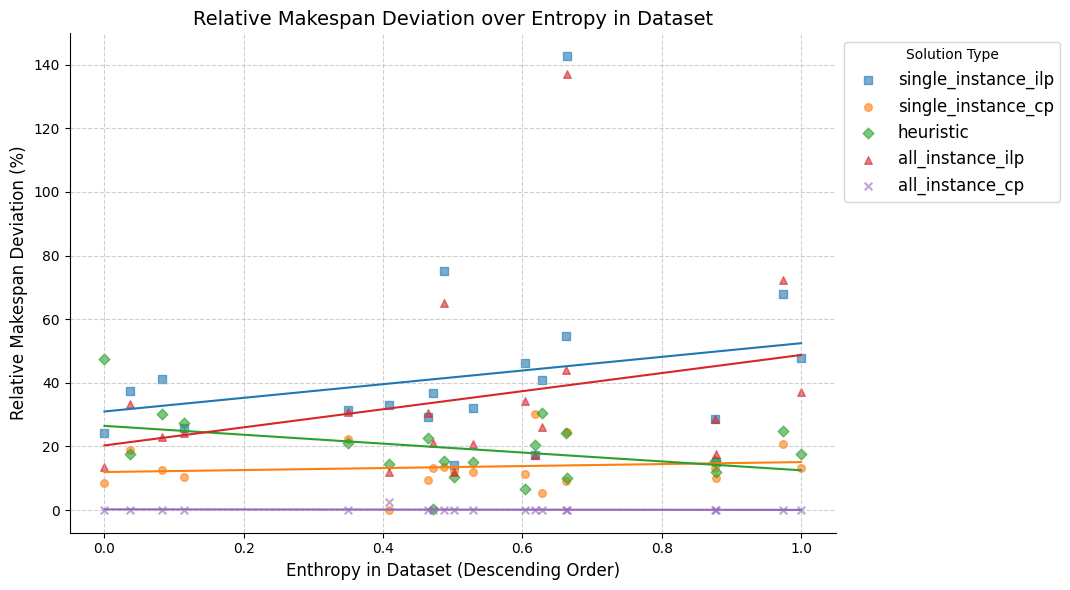

In [189]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)


marker_dict = {
    "all_instance_cp": "x",
    "single_instance_cp": "o",
    "heuristic": "D",
    "all_instance_ilp": "^",
    "single_instance_ilp": "s"
}

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
plot =sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    markers=[marker_dict[s] for s in visual_df["solution_type"].unique()],
    scatter_kws={'s': 30, 'alpha': 0.6},  # Customize scatter points
    line_kws={'linewidth': 1.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
)

# Add labels and title
# Remove extra legends
plot._legend.remove()
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation over Entropy in Dataset", fontsize=14)
plt.legend(title="Solution Type", fontsize=12, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


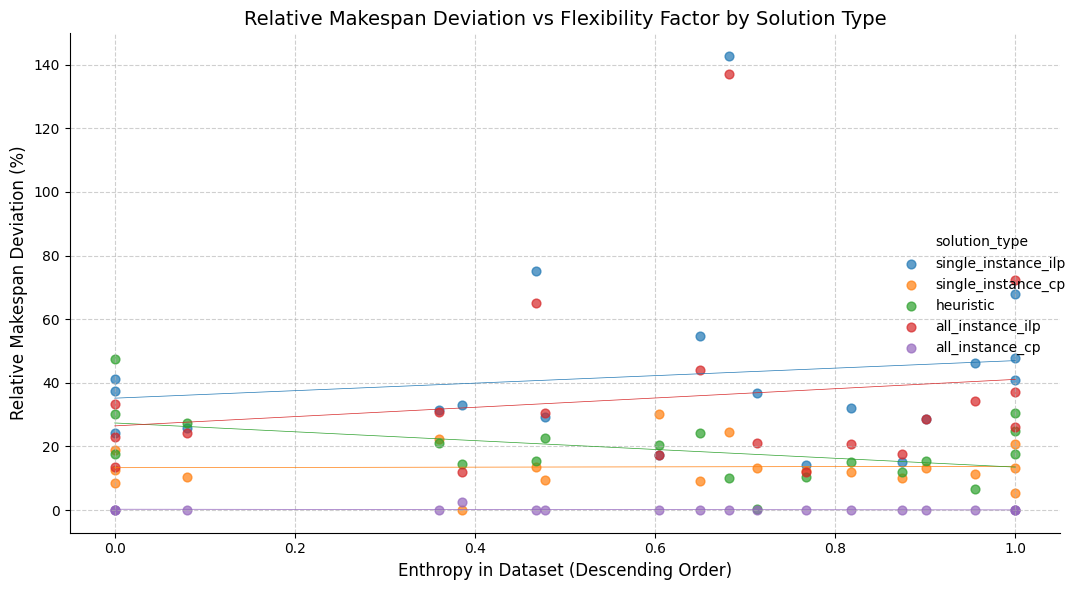

In [190]:
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 0.5},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5  # Aspect ratio
)

# Add labels and title
plt.xlabel("Enthropy in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


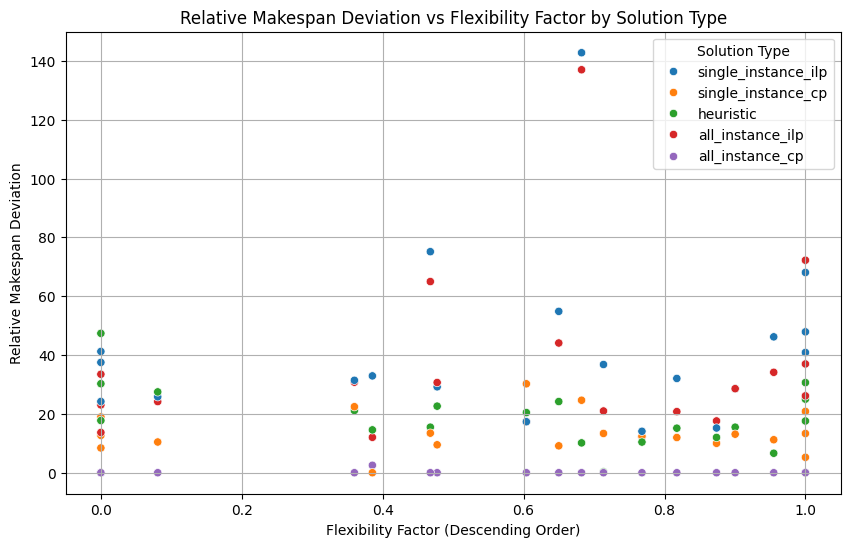

In [191]:
# Sort by flex_factor in descending order
#visual_df
visual_df = visual_df.sort_values(by='normalized_entropy', ascending=False)

# Create the lineplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=visual_df,
    x="normalized_entropy",
    y="relative_makespan_deviation",
    hue="solution_type",
    marker="o"
)

# Add labels and title
plt.xlabel("Flexibility Factor (Descending Order)")
plt.ylabel("Relative Makespan Deviation")
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type")
plt.legend(title="Solution Type")
plt.grid(True)
plt.show()

In [192]:
# concatenate eval_df1..4
dfs = [df.rename(columns={df.columns[0]: f"relative_makespan_deviation{suffix}"}) for df, suffix in zip([eval_df0, eval_df1, eval_df2, eval_df3, eval_df4], [suffix0, suffix1, suffix2, suffix3, suffix4])]
result = pd.concat(dfs, axis=1)
result

,relative_makespan_deviation_no_filter,relative_makespan_deviation_only_with_deletes,relative_makespan_deviation_early,relative_makespan_deviation_10_Tasks,relative_makespan_deviation_30_Tasks
solution_type,,,,,
all_instance_cp,0.000,0.000,0.00,0.000,0.000
single_instance_cp,12.535,11.205,10.44,11.295,12.325
heuristic,17.660,20.185,15.14,23.815,22.700
all_instance_ilp,27.350,25.155,20.98,29.615,22.015
single_instance_ilp,34.845,34.845,32.04,28.885,38.820


## Checks based on Arrival

In [193]:
objective_df = df[
    (df['release_type'] == 'arrival') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df5 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix5 = "differentiated_arrival"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,
all_instance_cp,214.285714,50.571429,0.285714,0.180714
single_instance_cp,237.285714,227.142857,23.285714,11.209286
heuristic,257.285714,NaN,43.285714,21.452143
all_instance_ilp,270.428571,269.071429,56.428571,28.885714
single_instance_ilp,291.714286,291.714286,77.714286,36.791429


In [194]:
objective_df = df[
    (df['release_type'] == 'same_release') &
    (df['config.cp_distribution_str'] != '1,0,0.0')
                ]
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation']]
eval_df6 = objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")[['relative_makespan_deviation']]
suffix6 = "same_release_Tasks"
objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation
solution_type,,,,


### Extra Checks


In [195]:

objective_df = df[['set_ident','solution_type', 'objective', 'min_objective']]
# Step 1: Get the min_objective for "all_instance_cp" for each set_ident
min_obj_cp = df[df["solution_type"] == "all_instance_cp"][["set_ident", "solution_type", "objective", "min_objective"]].reset_index()

# Step 2: Merge with the original dataframe to compare min_objective for each set_ident
df_merged = objective_df.join(min_obj_cp, on="set_ident", rsuffix=("_cp"))

# Step 3: Filter rows where the min_objective doesn't match the min_objective for "all_instance_cp"
filtered_df = df_merged[df_merged["min_objective"] != df_merged["objective_cp"]]

filtered_df

,set_ident,solution_type,objective,min_objective,index,set_ident_cp,solution_type_cp,objective_cp,min_objective_cp
index,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_cp,95.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_cp,103.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,all_instance_ilp,108.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,single_instance_ilp,118.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,heuristic,140.0,95.0,testsets_random_paper_smaller/10_generated/eva...,2.0,all_instance_cp,72.0,72.0
...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,all_instance_cp,589.0,589.0,NaN,NaN,NaN,NaN,NaN
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,heuristic,628.0,589.0,NaN,NaN,NaN,NaN,NaN
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json",20,single_instance_cp,655.0,589.0,NaN,NaN,NaN,NaN,NaN


In [196]:
objective_df
df_raw[df_raw['ilp_objective'].notna()][['ilp_objective', 'ilp_runtime']]

,ilp_objective,ilp_runtime
index,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000518
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",39.0,0.000371
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000455
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",33.0,0.000545
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json",50.0,0.000452
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json",50.0,0.000426
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",34.0,0.000576
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",34.0,0.000262
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json",61.0,0.000394


## Combined Solution

In [197]:
combined_solution_df

,objective,optimality gap,lower_bound,computing time,solver status,branches,propagations,total interval length,ilp_objective,ilp_runtime,...,config.resource_skill_factor,config.single_resource_option_per_task,config_name,solution_type,objective_combined,solver_status,lower_bound_combined,optimality_gap,computing_time,set_ident
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",103.0,N/A,103.0,0.45,Optimal,93277.0,N/A,332.0,NaN,NaN,...,0.6,true,"10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_cp,"[39, 47, 53, 64, 75, 86, 96, 103]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[39, 47, 53, 64, 75, 86, 96, 103]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.03, 0.06, 0.08, 0.05, 0.04, 0.06, 0.07, 0.06]",1
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(1, 0, 0.0)-random-3-early-resource_based-3-1-10.json",191.0,N/A,191.0,0.76,Optimal,83139.0,N/A,561.0,NaN,NaN,...,0.6,true,"10_generated(1, 0, 0.0)-random-3-early-resourc...",single_instance_cp,"[62, 76, 92, 111, 131, 151, 171, 191]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[62, 76, 92, 111, 131, 151, 171, 191]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.05, 0.09, 0.08, 0.11, 0.09, 0.11, 0.12, 0.11]",5
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-4-1-10.json",87.0,N/A,87.0,6.95,Optimal,286177.0,N/A,307.0,NaN,NaN,...,0.6,true,"10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_cp,"[34, 41, 46, 54, 61, 69, 74, 87]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[34, 41, 46, 54, 61, 69, 74, 87]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.36, 0.49, 0.75, 2.16, 2.03, 0.41, 0.26, 0.49]",2
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",95.0,N/A,95.0,2.38,Optimal,166896.0,N/A,298.0,NaN,NaN,...,0.6,true,"10_generated(0.8, 0.2, 0.0)-skill_short_branch...",single_instance_cp,"[35, 42, 49, 58, 65, 74, 84, 95]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[35, 42, 49, 58, 65, 74, 84, 95]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.22, 0.35, 0.26, 0.65, 0.25, 0.23, 0.16, 0.26]",4
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-early-normal-4-1-10.json",150.0,N/A,150.0,2.15,Optimal,159900.0,N/A,465.0,NaN,NaN,...,0.6,true,"10_generated(0.8, 0.2, 0.0)-skill_short_branch...",single_instance_cp,"[50, 64, 78, 92, 106, 121, 137, 150]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[50, 64, 78, 92, 106, 121, 137, 150]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.09, 0.2, 0.53, 0.25, 0.22, 0.4, 0.21, 0.25]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-normal-3-1-20.json",288.0,N/A,288.0,0.25,Optimal,304242.0,N/A,680.0,85.0,0.000366,...,0.6,true,"20_generated(0.6, 0.4, 0.0)-random-3-uniform-n...",single_instance_ilp,"[90, 112, 138, 164, 190, 216, 252, 288]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[90, 112, 138, 164, 190, 216, 252, 288]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.02, 0.03, 0.05, 0.02, 0.02, 0.02, 0.07]",8
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-skill_short_branch-3-uniform-normal-4-1-20.json",244.0,N/A,244.0,0.35,Optimal,313986.0,N/A,608.0,76.0,0.000462,...,0.6,true,"20_generated(0.6, 0.4, 0.0)-skill_short_branch...",single_instance_ilp,"[78, 93, 104, 129, 146, 213, 229, 244]","[Optimal, Optimal, Optimal, Optimal, Optimal, ...","[78, 93, 104, 129, 146, 213, 229, 244]","[0, 0, 0, 0, 0, 0, 0, 0]","[0.02, 0.03, 0.03, 0.04, 0.03, 0.02, 0.08, 0.1]",10
"testsets_random_paper_smaller/20_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-early-normal-2-1-20.json",229.0,N/A,229.0,0.21,Optimal,160530.0,N/A

## Parallelity Evaluation

In [198]:
data = load_evaluation_files( root_path = "testsets_random_paper_smaller")
df, combined_solution_df = generate_pandas_df(data, online=True)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['10_generated', '30_generated', '20_generated']
100 datasets loaded


/tmp/ipykernel_1831574/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [199]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]
visual_df

,config_name,solution_type,objective,lower_bound,makespan_deviation,relative_makespan_deviation,res_std_dev,normalized_entropy,normalized_entropy_all,parallelity_norm
index,,,,,,,,,,
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_cp,95.0,40.0,0.0,0.00,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_cp,103.0,103.0,8.0,8.42,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",all_instance_ilp,108.0,108.0,13.0,13.68,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",single_instance_ilp,118.0,118.0,23.0,24.21,2.283451,0.000000,0.000000,0.287273
"testsets_random_paper_smaller/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",heuristic,140.0,NaN,45.0,47.37,2.283451,0.000000,0.000000,0.287273
...,...,...,...,...,...,...,...,...,...,...
"testsets_random_paper_smaller/30_generated/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",all_instance_cp,589.0,61.0,0.0,0.00,3.427108,0.955017,0.604046,0.804371
"testsets_random_paper_smaller/30_generated/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",heuristic,628.0,NaN,39.0,6.62,3.427108,0.955017,0.604046,0.804371
"testsets_random_paper_smaller/30_generated/evaluation/single_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_generated(1, 0, 0.0)-skill_short_branch-3-u...",single_instance_cp,655.0,561.0,66.0,11.21,3.427108,0.955017,0.604046,0.804371


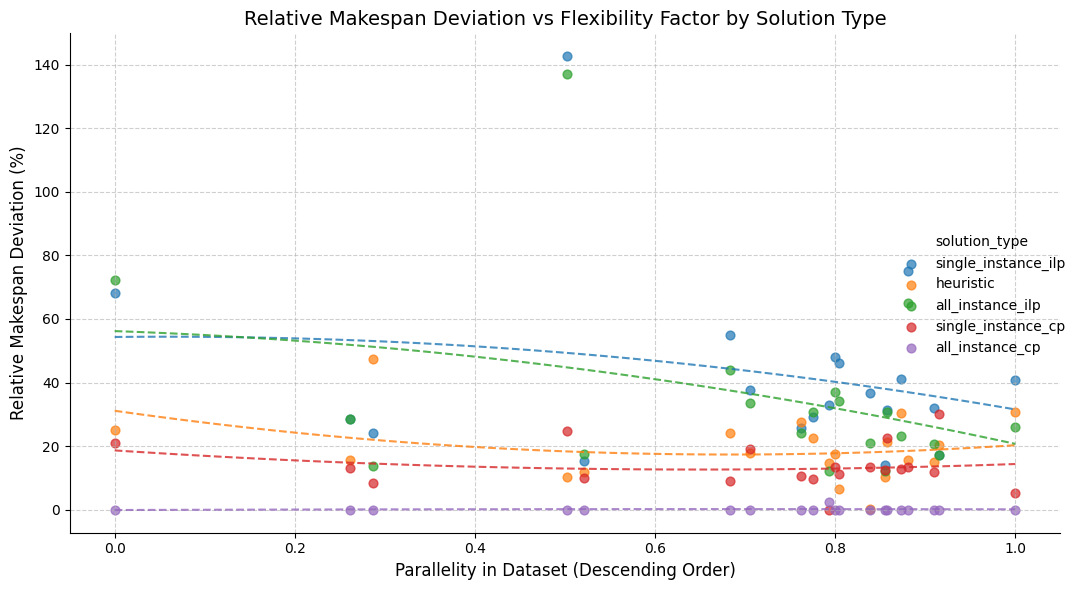

In [200]:
import numpy as np
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='parallelity_norm', ascending=False)

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
sns.lmplot(
    data=visual_df,
    x="parallelity_norm",
    y="relative_makespan_deviation",
    hue="solution_type",
    scatter_kws={'s': 40, 'alpha': 0.7},  # Customize scatter points
    line_kws={'linewidth': 2},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
    fit_reg=False
)

# Fit and plot non-linear trendlines
x_range = np.linspace(visual_df["parallelity_norm"].min(), visual_df["parallelity_norm"].max(), 100)

for solution in visual_df["solution_type"].unique():
    subset = visual_df[visual_df["solution_type"] == solution]
    if len(subset) < 3:
        continue  # Skip if not enough points for fitting
    
    # Fit a quadratic (2nd-degree) polynomial regression
    coefficients = np.polyfit(subset["parallelity_norm"], subset["relative_makespan_deviation"], deg=2)
    poly_model = np.poly1d(coefficients)
    
    # Plot the non-linear trendline
    plt.plot(x_range, poly_model(x_range), label=f"{solution} (trend)", linestyle="--", alpha=0.8)

# Add labels and title
plt.xlabel("Parallelity in Dataset (Descending Order)", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation vs Flexibility Factor by Solution Type", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Multi Instance Evaluation


In [201]:
data = load_evaluation_files( root_path = "testsets_random")
df, combined_solution_df = generate_pandas_df(data)
df = pre_process_df(df)
print(f"{len(data)} datasets loaded")

['10_instantArr', '10_generated', '30_instantArr', '30_generated', '20_instantArr', '20_generated']


ValueError: too many values to unpack (expected 2)

In [ ]:
df = df[['config_name', 'set_ident', 'parallelity', 'parallelity_norm', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'solution_type',  'objective', 'makespan_deviation', 'relative_makespan_deviation', 'deviation_to_heur', 'flex_factor', 'res_std_dev', 'tasks', 'release_type', 'min_objective', 'lower_bound', 'solver status',  'total interval length', 'resources','config.cp_distribution','config.branch_distribution','config.resource_allocation_type', 'config.cost_allocation', 'release_times',]]
df = df.sort_values(by=["set_ident", "objective", "enthropy"])
df

,config_name,set_ident,parallelity,parallelity_norm,enthropy,normalized_entropy,normalized_entropy_all,solution_type,objective,makespan_deviation,...,min_objective,lower_bound,solver status,total interval length,resources,config.cp_distribution,config.branch_distribution,config.resource_allocation_type,config.cost_allocation,release_times
index,,,,,,,,,,,,,,,,,,,,,
"testsets_random/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_cp,118.0,0.0,...,118.0,51.0,Feasible,426.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_cp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_cp_sigma_shift,132.0,14.0,...,118.0,132.0,Optimal,416.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/all_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,all_instance_ilp,134.0,16.0,...,118.0,134.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/single_instance_ilp_sigma_shift/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,single_instance_ilp_sigma_shift,153.0,35.0,...,118.0,153.0,Optimal,390.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
"testsets_random/10_generated/evaluation/heuristic/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json","10_generated(0.6, 0.4, 0.0)-random-3-uniform-r...",1,0.923077,0.384615,0.555786,0.000000,0.000000,heuristic,167.0,49.0,...,118.0,NaN,NaN,441.0,5,"[0.6, 0.4, 0.0]",uniform,random,resource_based,"[1, 10, 11, 12, 14, 14, 24, 28, 29, 31]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"testsets_random/30_instantArr/evaluation/all_instance_cp/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,all_instance_cp,776.0,0.0,...,776.0,26.0,Feasible,2509.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/single_instance_cp_sigma_shift/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,single_instance_cp_sigma_shift,785.0,9.0,...,776.0,741.0,Feasible,2101.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
"testsets_random/30_instantArr/evaluation/heuristic/(1, 0, 0.0)-skill_short_branch-3-uniform-resource_based-3-1-30.json","30_instantArr(1, 0, 0.0)-skill_short_branch-3-...",101,1.000000,1.000000,0.991804,0.904411,0.604046,heuristic,813.0,37.0,...,776.0,NaN,NaN,2269.0,5,"[1, 0, 0.0]",uniform,skill_short_branch,resource_based,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
objective_df = df
objective_df = objective_df[['solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'flex_factor', 'set_ident']]
objective_df.groupby(['solution_type']).median().sort_values(by="relative_makespan_deviation")

,objective,lower_bound,makespan_deviation,relative_makespan_deviation,flex_factor,set_ident
solution_type,,,,,,
all_instance_cp,272.0,51.0,0.0,0.000,2.0,51.5
single_instance_cp_sigma_shift,302.5,302.5,26.0,8.005,2.0,51.5
heuristic,303.0,NaN,35.5,14.530,2.0,51.5
all_instance_ilp,333.0,333.0,68.0,26.980,2.0,51.5
single_instance_ilp_sigma_shift,362.0,362.0,88.0,34.470,2.0,51.5
